# Load Library & Functions

In [1]:
import pandas as pd
import numpy as np
import h5py
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import seaborn as sns
import time
from time import gmtime, strftime, localtime
import statistics
np.random.seed(0)
%matplotlib inline

In [2]:
# Define functions for model evaluation
def accuracy(label, predicted):
    return np.sum(predicted == label)*100/ predicted.shape[0]

def confusion_matrix(label, predicted, normalised = True):
    confusion = pd.crosstab(label, predicted)
    
    #If true return the normalised form
    if normalised == True:
        confusion_normalised = confusion / confusion.sum(axis = 1)
        return confusion_normalised.values
        
    return confusion.values

# Load Data

In [3]:
#Get the input directory
input_dir = "../Input"

#Get the path for our training data
data_path = input_dir+"/"+"train_128.h5"

#Load training data
with h5py.File(data_path,'r') as H:
    data = np.copy(H['data'])

#Get directory for the label    
label_path = input_dir+"/"+"train_label.h5"

#Load training labels
with h5py.File(label_path,'r') as H:
    label = np.copy(H['label'])

#Get directory for the test data    
test_path = input_dir+"/"+"test_128.h5"

#Load test data
with h5py.File(test_path, 'r') as f:
    test = np.copy(f['data'])

# Data Preprocessing & Exploration

In [4]:
#Check the shape
print(pd.DataFrame(data).shape)

(60000, 128)


In [5]:
#Check the min values
print('lowest value:',np.min(data))
print('\nhighest value:',np.max(data))

lowest value: -2045.9187277548756

highest value: 2803.8364072606187


In [6]:
#Quick view at the dataset
pd.DataFrame(data).head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-126.502938,1632.432337,-1209.221451,248.416923,-0.602124,-404.695491,-93.129731,201.038160,-32.951419,-27.740150,...,-53.624163,51.010120,-38.099829,34.656913,-7.882829,-8.482584,-34.374911,111.837600,35.704495,-0.663193
1,1407.564794,-451.681446,-259.769757,368.518685,214.447195,1268.527449,-144.983974,-228.151550,-126.746831,-225.202768,...,30.160792,-30.173178,70.234457,-25.441815,67.777127,-38.934915,48.410126,92.488381,-146.637001,-79.309567
2,-725.430358,-1103.597632,107.005341,208.071611,-106.249946,-54.682297,-2.370448,50.642284,-97.019372,-79.594366,...,-3.905863,-23.349995,-12.270012,4.997900,40.159405,0.129521,-41.387057,-29.362293,13.054094,28.629644
3,31.557157,-981.872749,204.210125,375.511765,16.000261,183.780744,-112.367701,11.727588,-341.491224,92.673722,...,-2.595381,17.086888,48.338010,9.972216,-29.549497,28.632482,-29.292039,-34.426822,13.405224,0.072946
4,804.468286,-1201.982908,-747.112626,-265.420897,405.274689,-151.053642,231.037216,142.043787,7.617055,-159.925086,...,-99.168557,62.783179,-5.787661,24.112081,71.320464,-5.042983,2.254134,18.127838,-24.564781,207.819169


In [7]:
#Check for null values
null = pd.DataFrame(data).isnull().any()
null.sum()

0

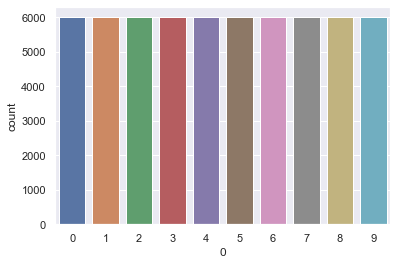

In [8]:
#Check label distribution
lb = pd.DataFrame(label)
sns.set(style="darkgrid")
ax = sns.countplot(x=0, data=lb)

In [9]:
#Create One Hot Encodding
levels = np.unique(label).shape[0]
encoded_label = np.zeros(shape=(label.shape[0],levels))

for i in range(label.shape[0]):
    pos = label[i]
    encoded_label[i][pos] = 1
    
encoded_label

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
#Standardised the training, validation and test data
train = data[:50000,:]
train = (train - np.mean(train)) / np.std(train)

validation = data[50000:,:]
validation = (validation - np.mean(validation)) / np.std(validation)

test = (test - np.mean(test)) / np.std(test)

# Machine Learning Model: MLP

In [11]:
class Activation(object):
    
    '''
    :list of supported activation functions:
    :- tanh
    :- softmax
    :- relu
    :- leaky relu
    '''
    
    #stable softmax implementation
    def __softmax(self, x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)
    
    #basic implementation of softmax
    def __softmax_deriv(self,a):
        s = a.reshape(-1,1)
        return np.diagflat(s) - np.dot(s, s.T)
    
    #ReLU activation function
    def __relu(self, x):
        x[np.where(x<=0)] = 0
        return np.nan_to_num(x)
    
    #Derivative of relu
    def __relu_deriv(self, a):
        a[np.where(a<=0)] = 0
        a[np.where(a>0)] = 1
        return np.nan_to_num(a)

    def __init__(self,activation='tanh'):
            
        if activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
            
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

In [12]:
class HiddenLayer(object):
    
    def __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None):

        self.input=None
        self.activation=Activation(activation).f
        self.vt=0
        self.activation_deriv=None
        
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv
            
        #Activation function check to determine the best weight initialisation method
        if activation == 'relu':
            n_tot = n_in
        else:
            n_tot = n_in +n_out
            
        #Weight initialization using Xavier uniform distribution
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_tot)),
                high=np.sqrt(6. / (n_tot)),
                size=(n_in, n_out))
        
        #Bias initialization
        self.b = np.zeros(n_out,) 
        
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        self.grad_W_wd = np.zeros(self.W.shape)
    
    #batch normalisation during forward propagation
    def bn_forward(self, input, gamma, beta):
        mu = np.mean(input, axis=0)
        var = np.var(input, axis=0)
        input_hat = (input - mu) / np.sqrt(var + 1e-8)
        output = gamma * input_norm + beta
        cache = (input, input_hat, mu, var, gamma, beta)
        return output, cache, mu, var
        
    #Foward Propagation step of the individual layer    
    def forward(self, input):
        lin_output = np.dot(input, self.W) + self.b
        #lin_output, self.bn_cache, self.mu, 
            #self.var = self.bn_forward(lin_output, self.gamma, self.beta)
        
        self.output = (lin_output if self.activation is None
                        else self.activation(lin_output))
        #self.mean_training = 0.9 * self.mean_training + 0.1 * self.mu
        #self.var_training = 0.9 * self.var_training + 0.1 * self.var
        self.input=input
        return self.output
    
    #batch normalisation during backward propagation    
    def bn_backward(delta, cache):
        input, input_hat, mu, var, gamma, beta = self.bn_cache
        N,_ = input.shape
        input_mu = input - mu
        std_inv = 1. / np.sqrt(var + 1e-8)
        d_norm = delta * gamma
        dvar = np.sum(d_norm * input_mu, axis=0) * -0.5 * std_inv**3
        dmu = np.sum(d_norm * -std_inv, axis=0) + dvar * np.mean(-2*input_mu, axis=0)
        d = (d_norm * std_inv) + (dvar * 2 * input_mu / N) + (dmu / N)
        dgamma = np.sum(delta * input_hat, axis=0)
        dbeta = np.sum(delta, axis=0)
        return d, dgamma, dbeta
   
    #update the batch noramlisation gamma and beta
    def bn_update(dgamma, dbeta):
        self.gamma += dgamma
        self.beta += dbeta
        return self.gamma, self.beta

    #Backward Propagation step of the individual layer
    def backward(self, delta, output_layer=False):
        self.grad_W = np.atleast_2d(self.input).T.dot(np.atleast_2d(delta))
        self.grad_b = delta
        if self.activation_deriv:
            delta = delta.dot(self.W.T) * self.activation_deriv(self.input) 
            #delta, self.dgamma, self.dbeta = self.bn_backward(delta, self.bn_cache)
            #self.gamma, self.beta = self.bn_update(self.dgamma, self.dbeta)        
        return delta
    
    #forward propagation for prediction with batch normalisation
    def forward_predict(self, input):
        lin_output = np.dot(inp, self.weight_matrix) + self.bias
        lin_output = forward_batch_test(self.gamma, self.beta, lin_output, self.mean_training, self.var_training)
        self.output = (lin_output if self.activation is None 
                       else self.activation(lin_output))
        return self.output
   
    #Weight Decay step of the individual layer
    def weight_decay(self, lambd):
        #Needed weight decay terms of each layer.
        weight_decay = np.square(self.W)*(lambd/2)
        #Storing the value for the weight decay gradient.
        self.grad_W_wd = self.grad_W + lambd * self.W 
        #Returning the weight_decay term that is added to the Cross Entropy loss.
        return weight_decay 
       
    #Momentum step of the individual layer
    def momentum (self, gamma, lr, lambd):
        #Combining the weight decay gradient with the momentum term.
        self.weight_decay(lambd)
        self.vt = gamma * self.vt + lr * self.grad_W_wd 
        #Returning the momentum update term for the weight updates.
        return self.vt 

In [13]:
class MLP:
    
    def __init__(self, layers, activation=[None,'relu','softmax'], dropout = 3, drop_p = 0.5):
        """
        :param layers: A list containing the number of units in each layer. Minimum two but can be more
        :param activation: The activation function to be used. Can be "relu", "tanh" or 'softmax'
        :param dropout: layer which dropout would be applied
        :param drop_p: probability for dropping the neuron in dropout layer
        """        
        ### initialize layers
        self.layers= []
        self.params=[]
        self.activation=activation
        self.dropout = dropout
        self.drop_p = 1 - drop_p
        self.drop = np.random.binomial(1, self.drop_p, size=layers[dropout - 1])
        self.weight_decay_sum = 0
        
        for i in range(len(layers)-1):
            self.layers.append(HiddenLayer(layers[i],layers[i+1],activation[i],activation[i+1]))
 

    #Called by the fit function to separate the training data into batches
    def batch(self,X,y,minibatch_size):
            #Divides the whole dataset in mini-batches.
            for i in range(0, X.shape[0], minibatch_size):
                #Get X minibatch/chunk.
                X_batch = np.array(X[i : i+minibatch_size])
                #Get y minibatch/chunk.
                y_batch = np.array(y[i : i+minibatch_size])
                return X_batch, y_batch
                
    #forward propagation        
    def forward(self,input):
        dl = 1
        for layer in self.layers:
            if dl == self.dropout:
                input = self.drop*input
            output=layer.forward(input)
            dl = dl + 1
            input=output
        return output
    
    #forward propagation during predict
    def forward_predict(self, input):
        dl = 1
        for layer in self.layers:
            if dl == self.dropout:
                input = self.drop*input
            output=layer.forward_predict(input)
            dl = dl + 1
            input=output
        return output
    
    #cross entropy loss function
    def cross_entropy(self,y_batch,y_hat):
        # Cross-entropy loss
        entropy_loss =  np.mean(-y_batch*np.log(y_hat + 1.00e-8))
        return entropy_loss
    
    #Calculate loss and derivative of loss
    def loss (self, y_batch, y_hat):
        cross_entropy_derivatives = -y_batch/y_hat
        loss = self.cross_entropy(y_batch, y_hat)#?I am not sure if the the weight decay term should count
        #to the actual loss function.?
        activation_deriv=Activation(self.activation[-1]).f_deriv
        delta= cross_entropy_derivatives @ activation_deriv(y_hat)#Without weight decay, since we need it without for the 
        #update of the bias term.
        return loss, delta
    
     #backward propagation
    def backward(self,delta):
        delta=self.layers[-1].backward(delta, output_layer=True)
        dl = 4
        for layer in reversed(self.layers[:-1]):
            if dl == self.dropout:
                delta = self.drop*delta
            delta=layer.backward(delta)
            dl = dl - 1
       
   #update parameters (weight and bias)  
    def update(self,lr, lambd, gamma):
        for layer in self.layers:
            layer.W -= layer.momentum(gamma, lr, lambd)# with weight decay gradient term "lambd * W".
            layer.b -= lr * layer.grad_b# without weight decay
      
    def fit(self,X,y,lr=0.1, lambd = 0.02, gamma = 0.9, epochs=100, minibatch_size = 128):
        """
        Online learning.
        :param X: Input data or features
        :param y: Input targets
        :param learning_rate: parameters defining the speed of learning
        :param epochs: number of times the dataset is presented to the network for learning
        """ 
        
        to_return = np.zeros(epochs)
        for k in range(epochs): 
            ent_loss=[]
            start=timer()
            for i in range(0, X.shape[0], minibatch_size):                
                X_batch = np.array(X[i : i+minibatch_size])
                y_batch = np.array(y[i : i+minibatch_size])            
                
                for it in range(X_batch.shape[0]):
                    qq=np.random.randint(X_batch.shape[0])

                    # forward pass
                    y_hat = self.forward(X_batch[qq])

                    # backward pass
                    ls,delta=self.loss(y_batch[qq],y_hat)
                    self.backward(delta)
                    ent_loss.append(ls)

                    # update
                    self.update(lr, lambd, gamma)#can stay the same.
            
            to_return[k] = statistics.mean(ent_loss)
            print('Epoch:',"{0:0=2d}".format(k+1),'------------------------------------','Loss:',
                  "{:.6f}".format(to_return[k]),"-- Duration", "{:.2f}".format(timer()-start),'sec')
            
        return to_return
            
    def predict(self, x):
        x = np.array(x)
        output = np.zeros((x.shape[0],10))
        for i in np.arange(x.shape[0]):
            output[i] = nn.forward(x[i,:])
        return output

# Model Training

In [17]:
#Define MLP parameters i.e. layers, neurons, activaiton functions etc.
nn = MLP([128,300,128,300,10], [None,'relu','relu','relu','softmax'], dropout = 3, drop_p = 0.12)

In [18]:
%%time
#Train MLP model
Loss = nn.fit(train, encoded_label[:50000], lr=0.001, lambd=0.001, gamma=0.6, epochs=13, minibatch_size =2048 )

Epoch: 01 ------------------------------------ Loss: 0.041926 -- Duration 52.79 sec
Epoch: 02 ------------------------------------ Loss: 0.031303 -- Duration 58.57 sec
Epoch: 03 ------------------------------------ Loss: 0.028759 -- Duration 57.12 sec
Epoch: 04 ------------------------------------ Loss: 0.027323 -- Duration 63.51 sec
Epoch: 05 ------------------------------------ Loss: 0.025502 -- Duration 60.22 sec
Epoch: 06 ------------------------------------ Loss: 0.024833 -- Duration 59.28 sec
Epoch: 07 ------------------------------------ Loss: 0.024738 -- Duration 53.82 sec
Epoch: 08 ------------------------------------ Loss: 0.023614 -- Duration 54.34 sec
Epoch: 09 ------------------------------------ Loss: 0.024119 -- Duration 53.79 sec
Epoch: 10 ------------------------------------ Loss: 0.023449 -- Duration 52.41 sec
Epoch: 11 ------------------------------------ Loss: 0.023060 -- Duration 52.36 sec
Epoch: 12 ------------------------------------ Loss: 0.022950 -- Duration 52

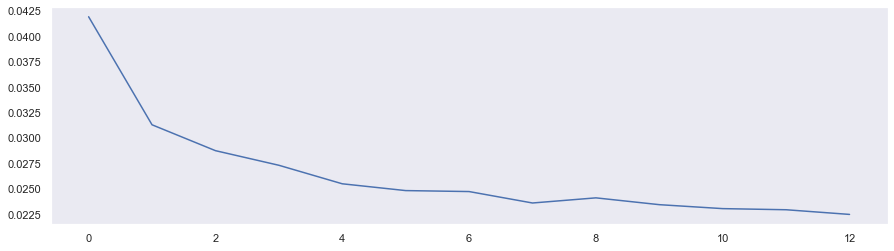

In [19]:
#plot the trainign loss vs epochs
plt.figure(figsize=(15,4))
plt.plot(Loss)
plt.grid()

# Model Evaluation

Check Training Accuracy

In [20]:
#get train predictions
output = nn.predict(train)
output_edited = output.argmax(axis=1)

In [21]:
#Calculate model training accuracy
accuracy(label[:50000], output_edited)

91.104

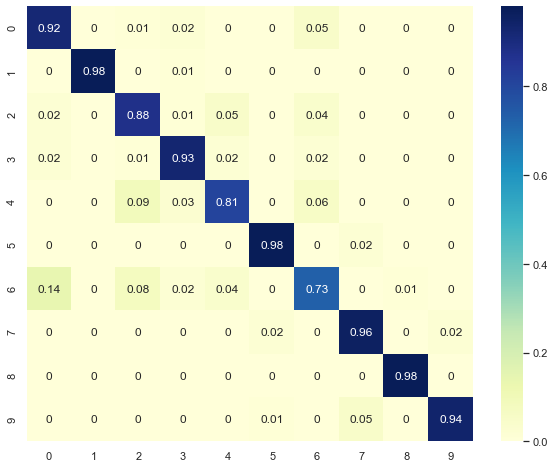

In [22]:
#Create confusion matrix for train prediction
cf = confusion_matrix(label[:50000], output_edited)

#visualise confusion matrix
import seaborn as sns; sns.set()
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
ax = sns.heatmap(cf.round(2),ax = ax, cmap="YlGnBu", annot=True)

Check Validation Accuracy

In [31]:
#Get the valiation prediction
output = nn.predict(validation)
output_edited = output.argmax(axis=1)

In [32]:
#Calculate model validation accuracy
accuracy(label[50000:], output_edited)

88.47

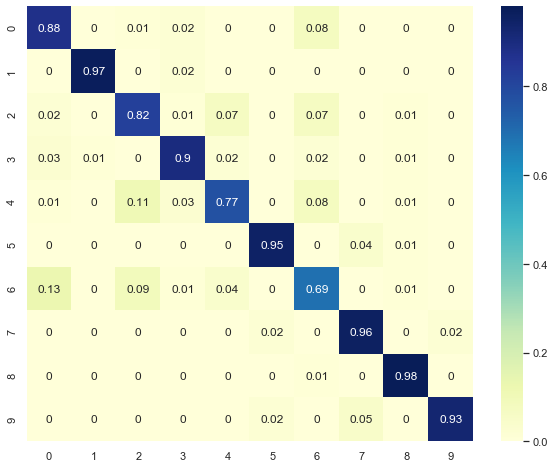

In [33]:
#Create confusion matrix for validation
cf = confusion_matrix(label[50000:], output_edited)

#visualise confusion matrix
import seaborn as sns; sns.set()
size = (10, 8)
fig, ax = plt.subplots(figsize=size)
ax = sns.heatmap(cf.round(2),ax = ax, cmap="YlGnBu", annot=True)

# Predict Test Labels

In [34]:
#Get the test prediction
predictions = nn.predict(test)
label_output = predictions.argmax(axis=1)

In [35]:
#Get the path andd directory to save test prediction
output_path = "../Output"+"/"+"predicted_labels.h5"

#save test prediction
with h5py.File(output_path, 'w') as f:
    f.create_dataset('predicted_labels', data=label_output)

In [36]:
#Get the input directory
input_dir = "../Output"

#Get the path for our training data
data_path = input_dir+"/"+"predicted_labels.h5"

#Load training data
with h5py.File(data_path,'r') as H:
    output_label = np.copy(H['predicted_labels'])

In [29]:
output_label

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)

In [30]:
label_output

array([9, 2, 1, ..., 8, 1, 5], dtype=int64)